<a href="https://colab.research.google.com/github/Tzutzu13/Final_Project2020/blob/master/AutoEncoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/Shared drives/USV RECORDINGS/

/content/drive/Shared drives/USV RECORDINGS


# **Importing neccessary libraries**

In [2]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sn
from pathlib import Path
import xlrd
from scipy import signal
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [161]:
from __future__ import print_function
from keras import backend as K
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D,Input,LeakyReLU,MaxPooling2D,Dropout,Lambda,add,Activation,Concatenate,Dense,Flatten,Conv2D
from keras.utils import plot_model
from keras.models import Model
# from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import seaborn as sns
def set_callbacks( name = 'best_model_weights',patience=8,tb_base_logdir='./logs/'):
    from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
    cp = ModelCheckpoint(name +'.h5',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)
    return [rlop, es, cp]
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(5,5)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)
def Remove_None_Data_and_lowering_Labels(data,labels):
    data = [j for i,j in enumerate(data) if j is not None] 
    labels= [j for i,j in enumerate(labels) if j is not None] 
    labels = [str(i) for i in labels]
    labels = [i.lower() for i in labels]
    return data, labels
def build_model(num_classes = 2):
    inp = Input(shape=(img_rows, img_cols,1))
    x = Conv2D(32, (3, 3), padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax')(x)
    return Model(inputs=inp, outputs=x)
def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name.lower()
    Syllables = Data[ind]
    return Syllables
def print_loss(hist):
    plt.figure()
    plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.legend(['loss','val_loss'])
    plt.figure()
    plt.plot(hist.history['accuracy'], 'r', hist.history['val_accuracy'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend(['accuracy','val_accuracy'])
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i in range(nrow*ncol):
        if preds is not None and i >= len(preds):
          continue
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        # ax[i//ncol,i%ncol].pcolormesh((X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if prob is None:
            ax[i//ncol,i%ncol].set_title([i])
        else:
            ax[i//ncol,i%ncol].set_title('im ' + str(i) +', prob = ' + str(round(prob[i][preds[i]],3)))
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='yellow' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    # plt.show()
    fig.suptitle(title,fontweight="bold", size=20)


# **Define relevant functions**

In [25]:
def shift_image(image, dx, dy,width = 28 , height = 28):
    image = image.reshape((width, height))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image

def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name.lower()
    Syllables = Data[ind]
    return Syllables
def PCA_function(Signal1,Signal2, title = 'PCA'):
 # the function gets 2 signals and performs 2 components PCA on them and plotting    
    pca = PCA(n_components=2)
    c = np.concatenate((Signal1,Signal2))
    if len(c.shape) != 2:
        c = c.reshape(c.shape[0], c.shape[1]**2)
    projected = pca.fit_transform(c)
    Label0 = np.zeros(len(Signal1))
    Label1 = np.ones(len(Signal2))
    Labels = np.concatenate((Label0,Label1))
    pca_data = np.vstack((projected.T, Labels)).T
    pca_df = pd.DataFrame(data=pca_data, columns=('1st_principal', '2nd_principal', 'label'))
    sn.FacetGrid(pca_df, hue='label', size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.title(title)
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0,title = 'plot_title',prob = None):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    for i in range(nrow*ncol):
        if preds is not None and i >= len(preds):
          continue
        ax[i//ncol,i%ncol].pcolormesh(20*np.log10(X[skip+i]))
        # ax[i//ncol,i%ncol].pcolormesh((X[skip+i]))
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if prob is None:
            ax[i//ncol,i%ncol].set_title([i])
        else:
            ax[i//ncol,i%ncol].set_title('im ' + str(i) +', prob = ' + str(round(prob[i][preds[i]],3)))
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='yellow' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    # plt.show()
    fig.suptitle(title,fontweight="bold", size=20)

# **Mnist Autoencoder for 2000 samples**

In [4]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

(x_train, _), (x_test, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.)[0:2000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(2000, 784)
(500, 784)
Train on 2000 samples, validate on 500 samples
Epoch 1/50
2000/2000 [==============================] - 0s 224us/step - loss: 0.2266 - val_loss: 0.2157
Epoch 2/50
2000/2000 [==============================] - 0s 16us/step - loss: 0.1950 - val_loss: 0.1672
Epoch 3/50
2000/2000 [==============================] - 0s 15us/step - loss: 0.1378 - val_loss: 0.1106
Epoch 4/50
2000/2000 [==============================] - 0s 15us/step - loss: 0.0934 - val_loss: 0.0819
Epoch 5/50
2000/2000 [==============================] - 0s 16us/step - loss: 0.0764 - val_loss: 0.0731
Epoch 6/50
2000/2000 [==============================] - 0s 16us/step - loss: 0.0715 - val_loss: 0.0699
Epoch 7/50
2000/2000 [==============================] - 0s 15us/step - loss: 0.0694 - val_loss: 0.0683
Epoch 8/50
2000/2000 [==============================] - 0s 16us/step - loss: 0.0680 - val_loss: 0.0670
Epoch 9/50
2000/2000 [==============================] - 0s 15us/step - loss: 0.0667 - val_loss: 0.0658
Ep

Text(0.5, 0, 'epoch')

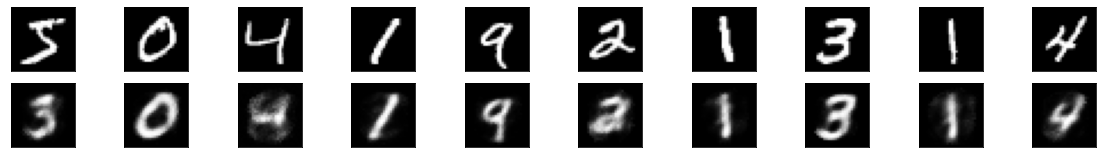

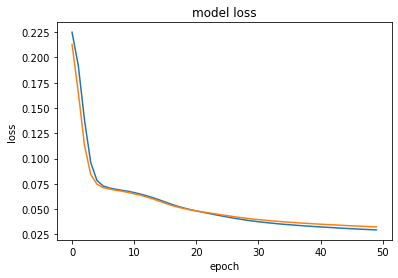

In [37]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# **Mnist Autoencoder for 10000 samples**

In [38]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

(x_train, _), (x_test, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.)[0:10000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(10000, 784)
(500, 784)
Train on 10000 samples, validate on 500 samples
Epoch 1/50
10000/10000 [==============================] - 0s 20us/step - loss: 0.1454 - val_loss: 0.0712
Epoch 2/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0684 - val_loss: 0.0628
Epoch 3/50
10000/10000 [==============================] - 0s 14us/step - loss: 0.0599 - val_loss: 0.0549
Epoch 4/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0521 - val_loss: 0.0492
Epoch 5/50
10000/10000 [==============================] - 0s 14us/step - loss: 0.0463 - val_loss: 0.0450
Epoch 6/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0424 - val_loss: 0.0418
Epoch 7/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0395 - val_loss: 0.0393
Epoch 8/50
10000/10000 [==============================] - 0s 12us/step - loss: 0.0372 - val_loss: 0.0373
Epoch 9/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0351 - 

Text(0.5, 0, 'epoch')

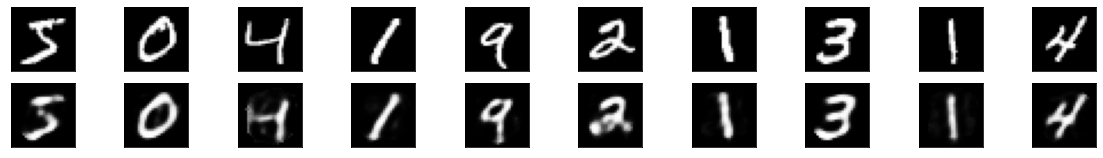

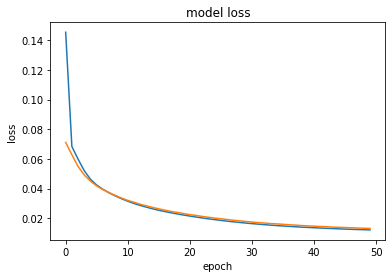

In [39]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')


# **Mnist Autoencoder augment to 10000 samples**

In [40]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')


# augment to 10000


# # Creating Augmented Dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.)[0:2000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train_augmented = [image for image in x_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
      for image in zip(x_train):
              x_train_augmented.append(shift_image(image[0], dx, dy))
x_train = np.asarray(x_train_augmented)
# x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(10000, 784)
(500, 784)
Train on 10000 samples, validate on 500 samples
Epoch 1/50
10000/10000 [==============================] - 0s 20us/step - loss: 0.1454 - val_loss: 0.0726
Epoch 2/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0699 - val_loss: 0.0646
Epoch 3/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0626 - val_loss: 0.0575
Epoch 4/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0553 - val_loss: 0.0512
Epoch 5/50
10000/10000 [==============================] - 0s 12us/step - loss: 0.0497 - val_loss: 0.0466
Epoch 6/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0455 - val_loss: 0.0430
Epoch 7/50
10000/10000 [==============================] - 0s 12us/step - loss: 0.0422 - val_loss: 0.0405
Epoch 8/50
10000/10000 [==============================] - 0s 13us/step - loss: 0.0395 - val_loss: 0.0379
Epoch 9/50
10000/10000 [==============================] - 0s 12us/step - loss: 0.0373 - 

Text(0.5, 0, 'epoch')

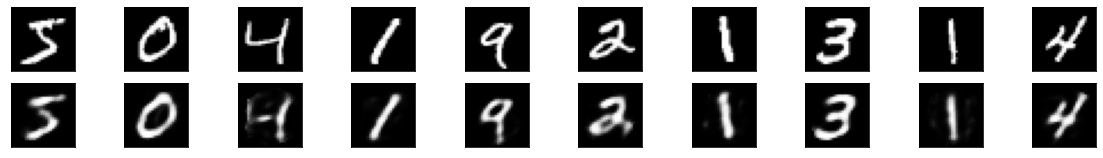

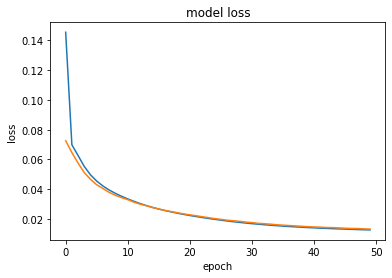

In [41]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# **Mnist Autoencoder for 2 categories - 6 & 3 , showing PCA**

In [42]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')
(x_train, y_train), (x_test, y_test) = mnist.load_data()
ind = (y_train == 6) | (y_train == 3)
ind_test =  (y_test == 6) | (y_test== 3)
x_train = x_train[ind]
y_train = y_train[ind]
x_test = x_test[ind_test]
y_test = y_test[ind_test]
# value, counts = np.unique(y_test,return_counts = True)
x_train = (x_train.astype('float32') / 255.)[0:1000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(1000, 784)
(500, 784)
Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 0s 86us/step - loss: 0.2282 - val_loss: 0.2236
Epoch 2/50
1000/1000 [==============================] - 0s 20us/step - loss: 0.2187 - val_loss: 0.2095
Epoch 3/50
1000/1000 [==============================] - 0s 18us/step - loss: 0.2002 - val_loss: 0.1853
Epoch 4/50
1000/1000 [==============================] - 0s 20us/step - loss: 0.1721 - val_loss: 0.1540
Epoch 5/50
1000/1000 [==============================] - 0s 19us/step - loss: 0.1396 - val_loss: 0.1224
Epoch 6/50
1000/1000 [==============================] - 0s 18us/step - loss: 0.1103 - val_loss: 0.0973
Epoch 7/50
1000/1000 [==============================] - 0s 19us/step - loss: 0.0897 - val_loss: 0.0816
Epoch 8/50
1000/1000 [==============================] - 0s 18us/step - loss: 0.0778 - val_loss: 0.0733
Epoch 9/50
1000/1000 [==============================] - 0s 19us/step - loss: 0.0718 - val_loss: 0.0695
Epo

Text(0.5, 0, 'epoch')

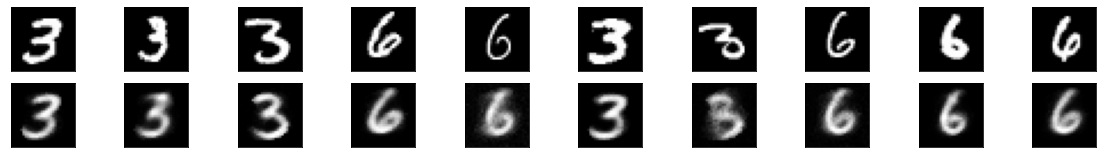

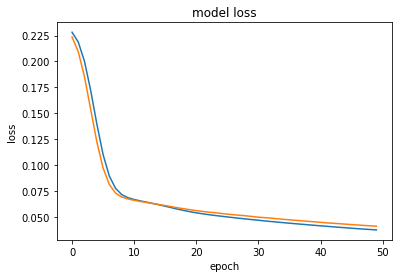

In [43]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [44]:
# augment to 5000
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
ind = (y_train == 6) | (y_train == 3)
ind_test =  (y_test == 6) | (y_test== 3)
x_train = x_train[ind]
y_train = y_train[ind]
x_test = x_test[ind_test]
y_test = y_test[ind_test]
# # Creating Augmented Dataset
# (x_train, _), (x_test, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.)[0:1000]
x_test = (x_test.astype('float32') / 255.)[0:500]
x_train_augmented = [image for image in x_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
      for image in zip(x_train):
              x_train_augmented.append(shift_image(image[0], dx, dy))
x_train = np.asarray(x_train_augmented)
# x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

(5000, 784)
(500, 784)
Train on 5000 samples, validate on 500 samples
Epoch 1/50
5000/5000 [==============================] - 0s 26us/step - loss: 0.1967 - val_loss: 0.1278
Epoch 2/50
5000/5000 [==============================] - 0s 13us/step - loss: 0.0872 - val_loss: 0.0668
Epoch 3/50
5000/5000 [==============================] - 0s 15us/step - loss: 0.0663 - val_loss: 0.0606
Epoch 4/50
5000/5000 [==============================] - 0s 14us/step - loss: 0.0603 - val_loss: 0.0561
Epoch 5/50
5000/5000 [==============================] - 0s 13us/step - loss: 0.0559 - val_loss: 0.0531
Epoch 6/50
5000/5000 [==============================] - 0s 13us/step - loss: 0.0528 - val_loss: 0.0504
Epoch 7/50
5000/5000 [==============================] - 0s 13us/step - loss: 0.0500 - val_loss: 0.0479
Epoch 8/50
5000/5000 [==============================] - 0s 13us/step - loss: 0.0473 - val_loss: 0.0455
Epoch 9/50
5000/5000 [==============================] - 0s 14us/step - loss: 0.0448 - val_loss: 0.0434
Epo

Text(0.5, 0, 'epoch')

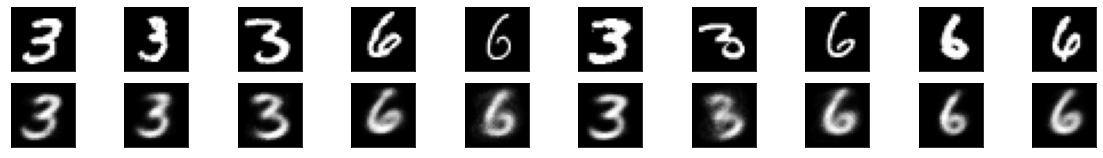

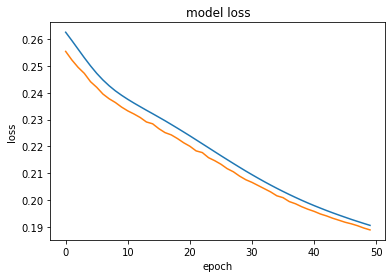

In [42]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(n):
    # display original
    plt.subplot(grid[0, i])
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    plt.subplot(grid[1, i])
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([]) 
    
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'upward and complex PCA for 200 samples')

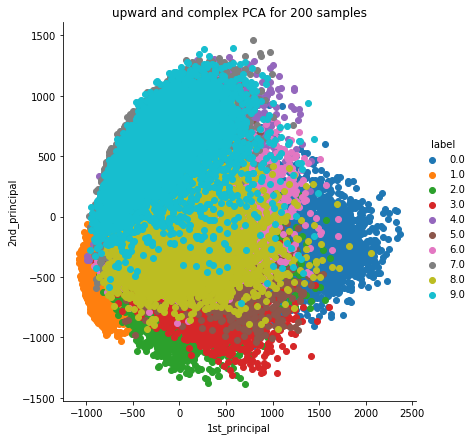

In [45]:
# PCA on all the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
pca = PCA(n_components=2)
c = x_train.reshape(60000,28*28)
# c = c.reshape(c.shape[:-1])
projected = pca.fit_transform(c)
Labels = y_train
import pandas as pd
import seaborn as sn
pca_data = np.vstack((projected.T, Labels)).T
pca_df = pd.DataFrame(data=pca_data, columns=('1st_principal', '2nd_principal', 'label'))
sn.FacetGrid(pca_df, hue='label', size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.title('upward and complex PCA for 200 samples')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


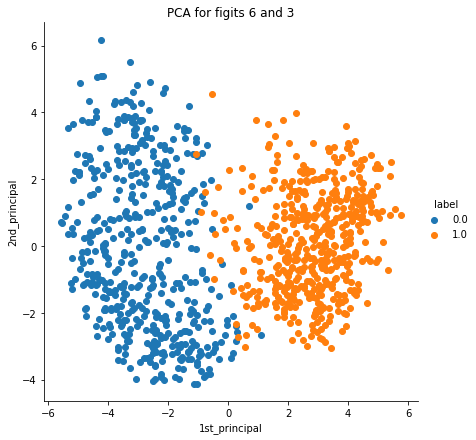

In [46]:
# PCA for two categories
(x_train, y_train), (x_test, y_test) = mnist.load_data()
ind = (y_train == 6)
ind1 = (y_train == 3)
ind_test =  (y_test == 6) | (y_test== 3)
x_train0 = (x_train[ind].astype('float32') / 255.)[0:500].reshape(500, 28*28)
x_train1 = (x_train[ind1].astype('float32') / 255.)[0:500].reshape(500, 28*28)
PCA_function(x_train0,x_train1, 'PCA for figits 6 and 3')  

# **Checking PCA for 2 different signals**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


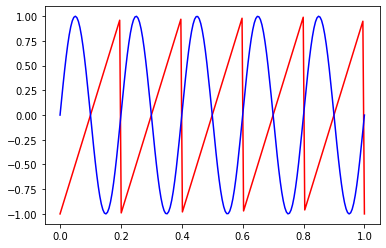

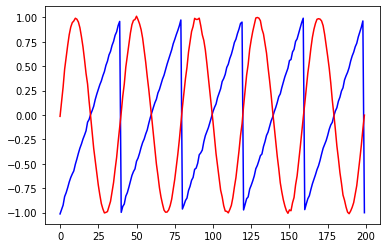

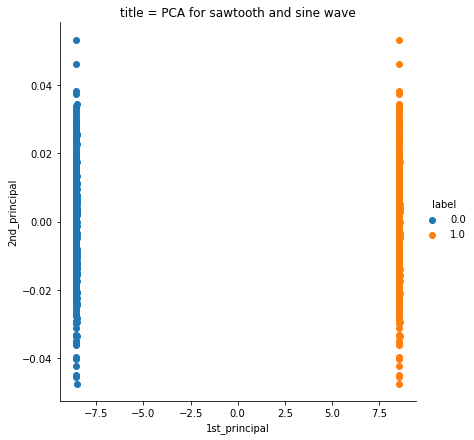

In [85]:
t = np.linspace(0, 1, 200)
saw_tooth = signal.sawtooth(2 * np.pi * 5 * t)
sine = np.sin(2 * np.pi * 5 * t)
plt.figure()
plt.plot(t, saw_tooth,'r', t, sine,'b')
L0 = np.zeros(500)
L1 = np.ones(500)
Labels = np.concatenate((L0,L1))
noise = np.random.normal(0,1,(500,len(t)))*0.01
sine = np.zeros((500,len(t)))
sine[:] = np.sin(2 * np.pi * 5 * t)
sine = sine + noise
saw_tooth = np.zeros((500,len(t)))
saw_tooth[:] = signal.sawtooth(2 * np.pi * 5 * t)
saw_tooth = saw_tooth + noise
plt.figure()
plt.plot(saw_tooth[0],'b')
plt.plot(sine[0],'r')

PCA_function(saw_tooth,sine,'title = PCA for sawtooth and sine wave')  

# **USV Autoencoder for 2 categories , showing PCA**

In [146]:
img_rows, img_cols = 64, 64 #choosing resize values
Data_united = np.load('Data_united.npy',allow_pickle = True)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data_united = np.array([scaler.fit_transform(i) for i in Data_united])

Labels_united = np.load('Labels_united.npy',allow_pickle = True)

Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('upward',Data_united,Labels_united)
flat_syl = Take_Syllables('flat',Data_united,Labels_united)
short_syl = Take_Syllables('short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('downward',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
Chevron_Labels = 2*np.ones((len(Chevron_syl)))
composite_Labels = 3*np.ones((len(Composite_syl)))
Noise_Labels = 4*np.ones((len(Noise_syl)))
two_syllable_Labels = 5*np.ones((len(two_syllable_syl)))
upward_Labels = 6*np.ones((len(upward_syl)))
flat_Labels = 7*np.ones((len(flat_syl)))
short_Labels = 8*np.ones((len(short_syl)))
harmonics_Labels = 9*np.ones((len(harmonics_syl)))
downward_Labels = 10*np.ones((len(downward_syl)))

In [151]:
labels, levels = pd.factorize(Labels_united)

In [152]:
x = Data_united
x = np.expand_dims(x,axis = -1)   
y = labels
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [162]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15

In [163]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(4096,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(4096, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')



X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

X_val = X_val.reshape((len(X_val), np.prod(X_val.shape[1:])))
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val, X_val))
encoded_imgs = encoder.predict(X_train)
decoded_imgs = decoder.predict(encoded_imgs)



Train on 1926 samples, validate on 328 samples
Epoch 1/100
1926/1926 [==============================] - 0s 75us/step - loss: 0.2259 - val_loss: 0.1973
Epoch 2/100
1926/1926 [==============================] - 0s 32us/step - loss: 0.1563 - val_loss: 0.0912
Epoch 3/100
1926/1926 [==============================] - 0s 31us/step - loss: 0.0607 - val_loss: 0.0322
Epoch 4/100
1926/1926 [==============================] - 0s 32us/step - loss: 0.0278 - val_loss: 0.0242
Epoch 5/100
1926/1926 [==============================] - 0s 32us/step - loss: 0.0241 - val_loss: 0.0234
Epoch 6/100
1926/1926 [==============================] - 0s 31us/step - loss: 0.0235 - val_loss: 0.0231
Epoch 7/100
1926/1926 [==============================] - 0s 33us/step - loss: 0.0233 - val_loss: 0.0229
Epoch 8/100
1926/1926 [==============================] - 0s 31us/step - loss: 0.0231 - val_loss: 0.0227
Epoch 9/100
1926/1926 [==============================] - 0s 30us/step - loss: 0.0230 - val_loss: 0.0226
Epoch 10/100
1926

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


dict_keys(['val_loss', 'loss'])


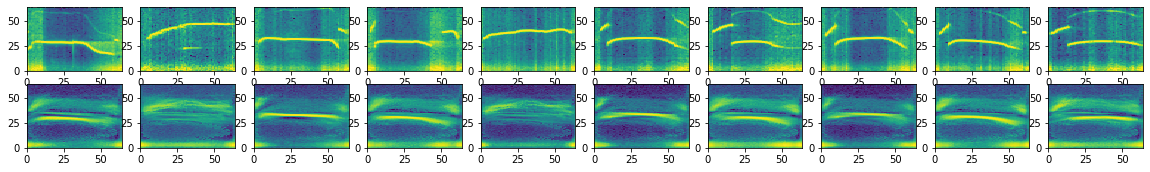

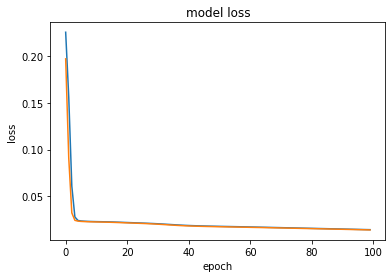

In [164]:
import matplotlib.pyplot as plt
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+100]).reshape(64, 64))
    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+100]).reshape(64, 64))

    

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
print(history.history.keys())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


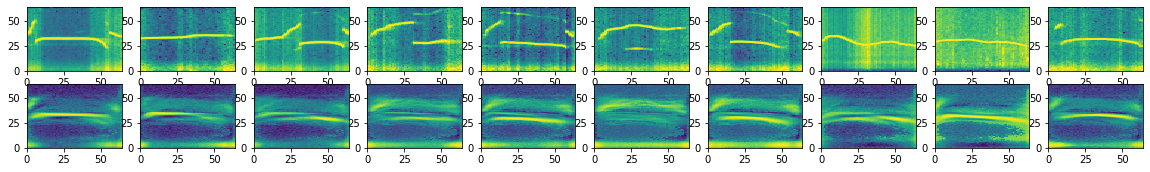

In [165]:
import matplotlib.pyplot as plt
n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    # display original
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+200]).reshape(64, 64))

    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+200]).reshape(64, 64))



In [166]:
from sklearn.cluster import KMeans

np.random.seed(10)
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters)
y_pred = kmeans.fit_predict(encoder.predict(X_train))


# correct = 0
# for k in range(n_clusters):
    
#     t = y_pred == k #clustering
#     c = [i for i, b in enumerate(t) if b] #counting 
#     u = max(np.bincount(y_train.astype(int)[c]))
#     print('count=',np.bincount(y_train.astype(int)[c]))
#     # print('y=',y[c])
#     correct += u

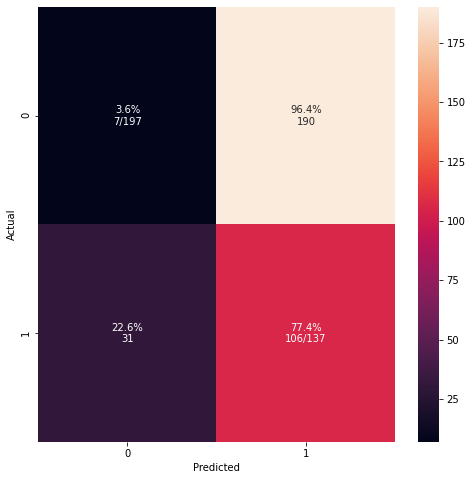

In [168]:
cm_analysis(y_pred,y_train , 'confusion matrix', np.arange(2),figsize=(8,8))

# cm_analysis(y_pred,y_train , 'confusion matrix', [0,1,2,3,4,5,6,7,8,9,10])

# check = y_test != pred
# c = [i for i,j in enumerate(check) if j]
# c_test = y_test[c]
# c_x_test = X_test[c].reshape(X_test[c].shape[:-1])
# c_pred = pred[c]
# c_prob = predictions[c]

In [ ]:
for i in range(30):
  plt.figure()
  plt.pcolormesh(20*np.log10(decoded_imgs[i+200]).reshape(64, 64))


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


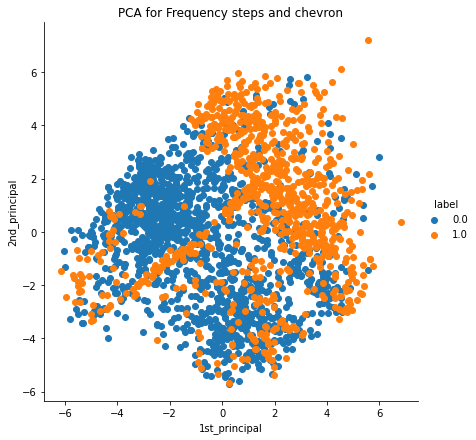

In [9]:
PCA_function(Frequency_steps_syl,Chevron_syl, title = 'PCA for Frequency steps and chevron')  

# **USV Autoencoder for 2 categories with augmentation , showing PCA**

In [ ]:
img_rows, img_cols = 64, 64 #choosing resize values
Data_united = np.load('Data_united.npy',allow_pickle = True)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data_united = np.array([scaler.fit_transform(i) for i in Data_united])

Labels_united = np.load('Labels_united.npy',allow_pickle = True)

Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('two-syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('upward',Data_united,Labels_united)
flat_syl = Take_Syllables('flat',Data_united,Labels_united)
short_syl = Take_Syllables('short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('downward',Data_united,Labels_united)

complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
Noise_Labels = 3*np.ones((len(Noise_syl)))

In [32]:
x = np.concatenate((Complex_syl,Frequency_steps_syl))
x = np.expand_dims(x,axis = -1)   
y = np.concatenate((complex_Labels,freq_Labels))  
x = x.astype('float32')
# x /= 255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42) # 0.17 x 0.85 ~= 0.15

In [39]:
#Augmentation
X_train = X_train.reshape(X_train.shape[:-1])
X_train_augmented = [image for image in X_train[:-1]]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image in zip(X_train):
             X_train_augmented.append(shift_image(image[0], dx, dy,64,64))

X_train = np.asarray(X_train_augmented)


In [40]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(4096,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(4096, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='mse')

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_val = X_val.reshape((len(X_val), np.prod(X_val.shape[1:])))
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val, X_val))
encoded_imgs = encoder.predict(X_train)
decoded_imgs = decoder.predict(encoded_imgs)

Train on 7989 samples, validate on 328 samples
Epoch 1/100
7989/7989 [==============================] - 0s 35us/step - loss: 0.1221 - val_loss: 0.0244
Epoch 2/100
7989/7989 [==============================] - 0s 27us/step - loss: 0.0237 - val_loss: 0.0228
Epoch 3/100
7989/7989 [==============================] - 0s 26us/step - loss: 0.0230 - val_loss: 0.0226
Epoch 4/100
7989/7989 [==============================] - 0s 25us/step - loss: 0.0228 - val_loss: 0.0223
Epoch 5/100
7989/7989 [==============================] - 0s 26us/step - loss: 0.0226 - val_loss: 0.0220
Epoch 6/100
7989/7989 [==============================] - 0s 27us/step - loss: 0.0222 - val_loss: 0.0216
Epoch 7/100
7989/7989 [==============================] - 0s 26us/step - loss: 0.0217 - val_loss: 0.0209
Epoch 8/100
7989/7989 [==============================] - 0s 26us/step - loss: 0.0210 - val_loss: 0.0202
Epoch 9/100
7989/7989 [==============================] - 0s 26us/step - loss: 0.0203 - val_loss: 0.0195
Epoch 10/100
7989

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


dict_keys(['val_loss', 'loss'])


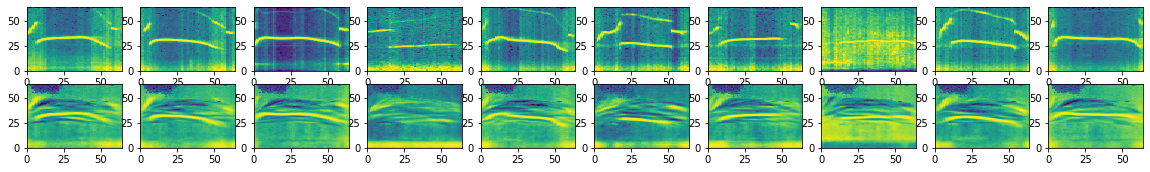

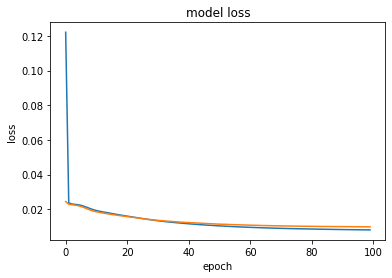

In [41]:
import matplotlib.pyplot as plt
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+100]).reshape(64, 64))
    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+100]).reshape(64, 64))
    
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
print(history.history.keys())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


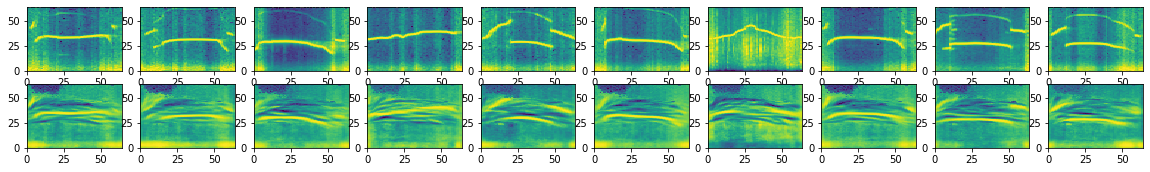

In [42]:
import matplotlib.pyplot as plt
n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))
grid = plt.GridSpec(3, 10)
for i in range(10):
    # display original
    plt.subplot(grid[0, i])
    plt.pcolormesh(20*np.log10(X_train[i+200]).reshape(64, 64))

    plt.subplot(grid[1, i])
    plt.pcolormesh(20*np.log10(decoded_imgs[i+200]).reshape(64, 64))

In [ ]:
for i in range(30):
  plt.figure()
  plt.pcolormesh(20*np.log10(decoded_imgs[i+200]).reshape(64, 64))


In [ ]:
from sklearn.cluster import KMeans

np.random.seed(10)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
y_pred = kmeans.fit_predict(encoder.predict(X_train))
correct = 0
for k in range(n_clusters):
    
    t = y_pred == k #clustering
    c = [i for i, b in enumerate(t) if b] #counting 
    u = max(np.bincount(y_train.astype(int)[c]))
    print('count=',np.bincount(y_train.astype(int)[c]))
    # print('y=',y[c])
    correct += u